## 파일 설명
| 파일명 | 파일 용도 | 관련 절 | 페이지 |
|:--   |:--      |:--    |:--      |
| apply_filter.py | cactus_gray.png 파일에 필터를 적용합니다. |  |  |
| gradient_check.py | SimpleCovNet이 기울기를 올바로 계산하는지 확인합니다. |  |  |
| params.pkl | 미리 학습된 가중치 값들입니다. |  |  |
| simple_convnet.py | “Convolution-ReLU-Pooling-Affine-ReLU-Affine-Softmax” 순으로 흐르는 단순한 합성곱 신경망(CNN)입니다. | 7.5 CNN 구현하기 | 251 |
| train_convnet.py | SimpleConvNet으로 MNIST 데이터셋을 학습합니다. | 7.5 CNN 구현하기 | 254 |
| visualize_filter.py | 합성곱 1번째 층의 가중치를 학습 전과 후로 나눠 시각화해봅니다. 이미 학습된 가중치 값(params.pkl)을 읽어서 사용하므로 학습 과정은 생략됩니다. | 7.6.1 1번째 층의 가중치 시각화하기 | 254 |

## 7장 합성곱 신경망(CNN)
이번 장의 주제는 합성곱 신경망(convolutional neural network, CNN)입니다. CNN은 이미지 인식과 음성 인식 등 다양한 곳에서 사용되는데, 특히 이미지 인식 분야에서 딥러닝을 활용한 기법은 거의 다 CNN을 기초로 하죠. 이번 장에서는 CNN의 메커니즘을 자세히 설명하고 이를 파이썬으로 구현해보겠습니다.

*옮긴이_ 합성곱은 공학과 물리학에서 널리 쓰이는 수학적 개념으로, 간단히 정의해보면 다음과 같습니다.
“두 함수 중 하나를 반전(reverse), 이동(shift)시켜가며 나머지 함수와의 곱을 연이어 적분한다.”
합성곱 신경망을 영어 발음 그대로 ‘컨벌루션 신경망’으로도 많이 씁니다만, 위 정의와 이번 장에서 설명할 동작 원리를 이해하고 나면 ‘합성곱 신경망’이란 용어가 더 직관적으로 다가올 수도 있을 겁니다.*   
https://cs231n.github.io/convolutional-networks/

## 목차
```
7.1 전체 구조 
7.2 합성곱 계층 
__7.2.1 완전연결 계층의 문제점 
__7.2.2 합성곱 연산 
__7.2.3 패딩 
__7.2.4 스트라이드 
__7.2.5 3차원 데이터의 합성곱 연산 
__7.2.6 블록으로 생각하기 
__7.2.7 배치 처리 
7.3 풀링 계층 
__7.3.1 풀링 계층의 특징 
7.4 합성곱/풀링 계층 구현하기 
__7.4.1 4차원 배열 
__7.4.2 im2col로 데이터 전개하기 
__7.4.3 합성곱 계층 구현하기 
__7.4.4 풀링 계층 구현하기 
7.5 CNN 구현하기 
7.6 CNN 시각화하기 
__7.6.1 1번째 층의 가중치 시각화하기 
__7.6.2 층 깊이에 따른 추출 정보 변화 
7.7 대표적인 CNN 
__7.7.1 LeNet 
__7.7.2 AlexNet 
```

- CNN의 네트워크 구조를 살펴보며 전체 틀을 이해해보기로 한다. CNN도 지금까지 본 신경망과 같이 레고 블록처럼 계층을 조합하여 만들 수 있습니다. 다만, 합성 곱 Convolutional layer과 풀링 계층 pooling layer이 새롭게 등장합니다. 합성곱 계층과 풀링 계층의 상세 내용은 잠시 후 설명하기로 하고, 이번 절에서는 이 계층들을 어떻게 조합하여 CNN을 만드는지를 먼저 보겠습니다. 지금까지 본 신경망은 인접하는 계층의 모든 뉴런과 결합되어 있었습니다. 이를 완전연결 fully connected, 이라고 하며, 완전히 연결된 계층을 Affine 게층이라는 이름으로 구현했습니다. 

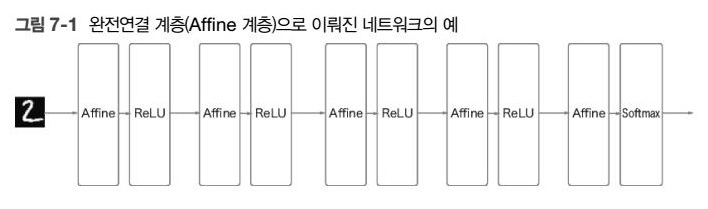
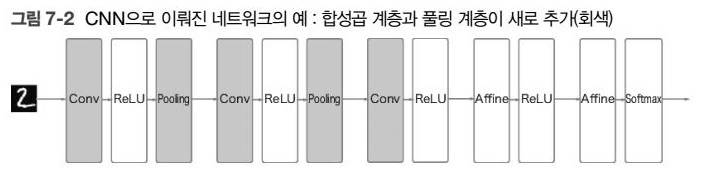

- CNN에서는 패딩 padding, 스트라이드 stride 등 CNN 고유의 용어가 등장합니다. 또, 각 계층 사이에는 3차운 데이터같이 입체적인 데이터가 흐른다는 점에서 완전 연결 신경망과 다릅니다. 
- 완전 연결 계층의 문제점 : 데이터의 형상이 무시됩니다. 입력 데이터가 이미지인 경우를 예로 들면, 이미지는 통상 세로, 가로, 채널(색상)로 구성된 3차원 데이터입니다. 그러나 완전연결 계층에 입력할 때는 3차원 데이터를 평평한 1차원 데이터로 평탄화해줘야 합니다. 사실 지금까지의 MNIST 데이터셋을 사용한 사례에서는 형상이 (1, 28, 28)인 이미지(1채널, 세로 28픽셀, 가로 28픽셀)를 1줄로 세운 784개의 데이터를 첫 Affine 계층에 입력했습니다.  
- 이미지는 3차원 형상이며, 이 형상에는 소중한 공간적 정보가 담겨 있죠. 예를 들어 공간적으로 가까운 픽셀은 값이 비슷하거나, RGB의 각 채널은 서로 밀접하게 관련되어 있거나, 거리가 먼 픽셀끼리는 별 연관이 없는 등, 3차원 속에서 의미를 갖는 본질적인 패턴이 숨어 있을 것입니다. 그러나 완전연결 계층은 형상을 무시하고 모든 입력 데이터를 동등한 뉴런(같은 차원의 뉴런)으로 취급하여 형상에 담긴 정보를 살릴 수 없습니다.
- 한편, 합성곱 계층은 형상을 유지합니다. 이미지도 3차원 데이터로 입력받으며, 마찬가지로 다음 계층에도 3차원 데이터로 전달합니다. 그래서 CNN에서는 이미지처럼 형상을 가진 데이터를 제대로 이해할(가능성이 있는) 것입니다.
- CNN에서는 합성곱 계층의 입출력 데이터를 feature map 이라고도 합니다. 합성곱 계층의 입력데이터를 input feature map, 출력 데이터를 output feature map이라고 하는 식입니다. **입출력 데이터 == 특징 맵 feature map**

# 패딩 
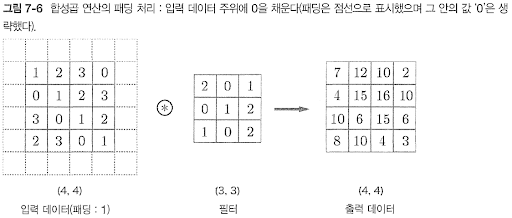
패딩은 주로 출력 크기를 조정할 목적으로 사용합니다. 예를 들어 (4,4) 입력 데이터에 (3,3) 필터를 적용하면 출력은 (2,2)가 되어, 입력보다 2만큼 줄어듭니다. 이는 합성곱 연산을 몇 번이나 되풀이하는 심층 신경망에서는 문제가 될 수 있습니다. 합성곱 연산을 거칠 때마다 크기가 작아지면 어느 시점에서는 출력 크기가 1이 되어버리겠죠. 더 이상은 합성곱 연산을 적용할 수 없다는 뜻입니다. 이러한 사태를 막기 위해 패딩을 사용합니다. 앞의 예에서는 패딩의 폭을 1로 설정하니 (4,4) 입력에 대한 출력이 같은 크기인 (4,4)로 유지되었습니다. 한 마디로 입력 데이터의 공간적 크기를 고정한 채로 다음 계층에 전달할 수 있습니다. 

In [2]:
import numpy as np
x=np.random.rand(10,1,28,28)
x.shape

(10, 1, 28, 28)

In [3]:
x[0].shape
x[1].shape

(1, 28, 28)

In [4]:
x[0,0]

array([[0.9965895 , 0.59215978, 0.53558328, 0.10453817, 0.66823618,
        0.284486  , 0.27852934, 0.12832933, 0.24341079, 0.05258839,
        0.28070641, 0.67503775, 0.67590865, 0.37300612, 0.9032379 ,
        0.71444098, 0.34567961, 0.53886815, 0.42838566, 0.07483097,
        0.78349638, 0.12368671, 0.98490499, 0.21905264, 0.66552589,
        0.95821995, 0.33269765, 0.77762364],
       [0.7274318 , 0.81082758, 0.26313774, 0.61033805, 0.17162262,
        0.48961669, 0.89029712, 0.99706254, 0.11563788, 0.53772465,
        0.69210799, 0.2870311 , 0.54796978, 0.84584473, 0.03472491,
        0.09477883, 0.80057365, 0.55145467, 0.1886236 , 0.52811258,
        0.12111103, 0.80199422, 0.92222083, 0.2895717 , 0.1441804 ,
        0.29251643, 0.96331718, 0.75961699],
       [0.73030412, 0.96634748, 0.14868776, 0.55175193, 0.11907315,
        0.25814778, 0.73688896, 0.5725521 , 0.6618566 , 0.01318849,
        0.22429642, 0.80762462, 0.51527704, 0.12606326, 0.75416295,
        0.35424498, 0.3878

# 합성곱 계층 구현하기

In [5]:
import sys,os
sys.path.append(os.pardir)
from common.util import im2col

x1=np.random.rand(1,3,7,7)
col1=im2col(x1,5,5,stride=1,pad=0)
print(col1.shape)

x2=np.random.rand(10,3,7,7)
col2=im2col(x2,5,5,stride=1,pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [6]:
class Convolution:
    def __init__(self,W,b,stride=1,pad=0):
        self.W=W
        self.b=b
        self.stride=stride
        self.pad=pad
    def forward(self,x):
        FN,C,FH,FW=se;f.W.shape
        N,C,H,W=x.shape
        out_h=int(1+(H+2*self.pad-FH)/self.stride)
        out_w=int(1+(W+2*self.pad-FW)/self.stride)
        
        col=im2col(x,FH,FW,self.stride,self.pad)
        col_W=self.W.reshape(FN,-1).T
        out=np.dot(col,col_W)+self.b
        
        out=out.reshape(N,out_h,out_w,-1).transpose(0,3,1,2)
        
        return out

FN : 필터 개수, C : 채널, FH : 필터 높이, FW : 필터 너비

In [7]:
class Pooling:
    def __init__(self,pool_h,pool_w,stride=1,pad=0):
        self.pool_h=pool_h
        self.pool_w=pool_w
        self.stride=stride
        self.pad=pad
    
    def forward(self,x):
        N,C,H,W=x.shape
        out_h=int(1+(H-self.pool_h)/self.stride)
        out_w=int(1+(W-self.pool_w)/self.stride)
        
        # 전개 1
        col=im2col(x,self.pool_h,self.pool_w,self.stride,self.pad)
        col=col.reshape(-1,self.pool_h*self.pool_w)
        
        #최댓값
        out=np.max(col,axis=1)
        
        #성형
        out=out.reshape(N,out_h,out_w,C).transpose(0,3,1,2)
        
        return out

풀링 계층 구현은 다음의 세 단계로 진행한다.
1. 입력 데이터를 전개한다.
2. 행별 최댓값을 구한다.
3. 적절한 모양으로 성형한다.

최댓값 계산에는 넘파이의 np.max 메서드를 사용할 수 있습니다. np.max는 인수로 축(axis)을 지정할 수 있는데, 이 인수로 지정한 축마다 최댓값을 구할 수 있습니다. 가령 np.max(x,axis=1)과 같이 쓰면 입력 x의 1번째 차원의 축마다 최댓값을 구합니다.

# CNN 구현하기

In [1]:
class SimpleConvNet:
    def __init__(self,input_dim=(1,28,28),
                conv_param={'filter_num':30,'filter_size':5,'pad':0,'stride':1},
                hidden_size=100,output_size=10,weight_init_std=0.01):
        filter_num=conv_param['filter_num']
        filter_size=conv_param['filter_size']
        filter_pad=conv_param['pad']
        filter_stride=conv_param['stride']
        input_size=input_dim[1]
        conv_output_size=(input_size-filter_size+2*filter_pad)/filter_stride+1
        pool_output_size=int(filter_num*(conv_output_size/2)*(conv_output_size/2))
        
        #가중치 매개변수 초기화
        self.params={}
        self.params['W1']=weight-init_std*np.random.randn(filter_num,input_dim[0],filter_size,filter_size)
        self.params['b1']=np.zeros(filter_num)
        self.params['W2']=weight_init_std*np.random.randn(pool_output_size,hidden_size)
        self.params['b2']=np.zeros(hidden_size)
        self.params['W3']=weight_init_std*np.random.randn(hidden_size,output_size)
        self.params['b3']=np.zeros(output_size)
        
        ##CNN 구성 계층
        self.layers=OrderedDict()
        self.layers['Conv1']=Convolution(self.params['W1'],
                                        self,params['b1'],
                                        conv_param['stride'],
                                        conv_param['pad'])
        self.layers['Relu1']=Relu()
        self.layers['Pool1']=Pooling(pool_h=2,pool_w=2,stride=2)
        self.layers['Affine1']=Affine(self.params['W2'],
                                     self.params['b2'])
        self.layers['Relu2']=Relu()
        self.layers['Affine2']=Affine(self.params['W3'],
                                     self.params['b3'])
        self.last_layer=SoftmaxWithLoss()

In [2]:
def precidt(self,x):
    for layer in self.layers.values():
        x=layer.forward(x)
    return x
def loss(self,x,t):
    y=self.predict(x)
    return self.last_layer.forward(y,t)

- 오차역전파법으로 기울기 구하기

In [4]:
def gradient(self,x,t):
    #순전파
    self.loss(x,t)
    
    #역전파
    dout=1
    dout=self.last_layer.backward(dout)
    
    layers=list(self.layers.values())
    layers.reverse()
    for layer in layers:
        dout=layer.backward(dout)
        
    #결과저장
    grads={}
    grads['W1']=self.layers['Conv1'].dW
    grads['b1']=self.layers['Conv1'].db
    grads['W2']=self.layers['Affine1'].dW
    arads['b2']=self.layers['Affine1'].db
    grads['W3']=self.layers['Affine2'].dW
    grads['b3']=self.layers['Affine2'].db
    
    return grads

train loss:2.2999226046988968
=== epoch:1, train acc:0.219, test acc:0.245 ===
train loss:2.297578280415694
train loss:2.2938118650560995
train loss:2.2911835810645584
train loss:2.2835566924529105
train loss:2.276378176239983
train loss:2.260818478741479
train loss:2.2494635514229024
train loss:2.2313866788563756
train loss:2.2007877031537726
train loss:2.174950794764067
train loss:2.143249852019575
train loss:2.114234549606294
train loss:2.0463861861269423
train loss:1.9846751254582227
train loss:1.9421553099892568
train loss:1.8407893249719374
train loss:1.8459398651173011
train loss:1.7611048043734276
train loss:1.6159131289707078
train loss:1.5481872323224544
train loss:1.5063810598494003
train loss:1.4567392627102962
train loss:1.2946595837001942
train loss:1.174730369953722
train loss:1.138141355957969
train loss:1.190573310372632
train loss:0.9060844790478824
train loss:1.0402783006515934
train loss:0.8218165083547292
train loss:0.8679816595737695
train loss:0.7278265024254337


train loss:0.2499851070203926
train loss:0.28066699674240303
train loss:0.16423732455661583
train loss:0.23368726598746326
train loss:0.1805913031556901
train loss:0.29017910706785227
train loss:0.23284687343755522
train loss:0.2530565494714847
train loss:0.23522953940721783
train loss:0.16454651017813493
train loss:0.24172990503890726
train loss:0.1383142141016477
train loss:0.2684058875295759
train loss:0.16020107440717746
train loss:0.18571080204350085
train loss:0.25161444865265103
train loss:0.11703189282988129
train loss:0.22098779277990865
train loss:0.17789089889828183
train loss:0.2816343454727168
train loss:0.18441679768098904
train loss:0.1461339674123382
train loss:0.1709458370658382
train loss:0.30125273621433757
train loss:0.3215196306797211
train loss:0.17672581785915706
train loss:0.17578211565139515
train loss:0.21752452492919366
train loss:0.21001309748957755
train loss:0.2649444683859727
train loss:0.18858386295949547
train loss:0.230851414356737
train loss:0.2058445

train loss:0.06880385860407973
train loss:0.1566200838619513
train loss:0.16933757327283622
train loss:0.08942296004013714
train loss:0.1329205517901095
train loss:0.17449268463832465
train loss:0.13448645183332236
train loss:0.12526495123062012
train loss:0.12480332246237046
train loss:0.11620662778086982
train loss:0.19513455255388837
train loss:0.053162204017673
train loss:0.08356768553639306
train loss:0.08654519608230293
train loss:0.11066120707188354
train loss:0.08811363656946253
train loss:0.19388776371216693
train loss:0.10307959956394944
train loss:0.10726586109118333
train loss:0.12285725993410791
train loss:0.11664060973714765
train loss:0.17211949013054542
train loss:0.07555020143872541
train loss:0.134996944799547
train loss:0.2124719046929411
train loss:0.08397676974642865
train loss:0.12204773316878907
train loss:0.15395624965210078
train loss:0.1756601951012739
train loss:0.12001048831435393
train loss:0.08381400129623817
train loss:0.12142394358635919
train loss:0.218

train loss:0.10054170095832045
train loss:0.06039647379433728
train loss:0.08004362242541284
train loss:0.06662673194329001
train loss:0.10020206486388616
train loss:0.03447080131217106
train loss:0.07419032544164139
train loss:0.09677365155929715
train loss:0.16848600328549213
train loss:0.15325337817322437
train loss:0.047882154070500046
train loss:0.038612145932591525
train loss:0.12139938541436818
train loss:0.05363486100951605
train loss:0.07909115417568716
train loss:0.09337052309482606
train loss:0.06848249753434574
train loss:0.14974975760199874
train loss:0.03072639944850367
train loss:0.09399009204235353
train loss:0.0959560887147786
train loss:0.0481963427752498
train loss:0.129918365018105
train loss:0.10080265556095354
train loss:0.06281979611785801
train loss:0.07264523108078576
train loss:0.036288070293485596
train loss:0.1410776818780322
train loss:0.08622007961100353
train loss:0.10505760489194005
train loss:0.032371587712272824
train loss:0.03411799703897566
train los

train loss:0.030721373983513444
train loss:0.07144903740191873
train loss:0.11301444728795283
train loss:0.05346728551290215
train loss:0.026593688921586704
train loss:0.020086052891957796
train loss:0.03903416917937333
train loss:0.12522905492816186
train loss:0.09164331507212267
train loss:0.02628496396709193
train loss:0.09206198720602682
train loss:0.05240913007930856
train loss:0.03773779082998767
train loss:0.09047022028728904
train loss:0.02032654575621111
train loss:0.18540693971212555
train loss:0.15048721595691408
train loss:0.07844257775874477
train loss:0.10224562271553973
train loss:0.09087603974917506
train loss:0.08493518898832185
train loss:0.032920627293474336
train loss:0.07853798468145995
train loss:0.17927897701483492
train loss:0.06156315855840864
train loss:0.03939190780946336
train loss:0.09893265609826014
train loss:0.04804921421056453
train loss:0.052318843010983704
train loss:0.09535844314991757
train loss:0.04865843566153271
train loss:0.0549199873350537
trai

train loss:0.023926725070993048
train loss:0.04579525508729772
train loss:0.09333493862960748
train loss:0.040382985879954515
train loss:0.0334736233899493
train loss:0.011160928366476213
train loss:0.02639077128154732
train loss:0.11642309679441162
train loss:0.021972070118845978
train loss:0.030044873066738975
train loss:0.06556699070091422
train loss:0.041805522681127576
train loss:0.07698340534893439
train loss:0.08573964531691079
train loss:0.06059133870598709
train loss:0.21796798982637802
train loss:0.030334060246746716
train loss:0.10057969068260254
train loss:0.0906600420239442
train loss:0.0648254379793536
train loss:0.05818786614726495
train loss:0.06218216003451285
train loss:0.10597766019217186
train loss:0.02090944598864572
train loss:0.06348061153811733
train loss:0.02522759835329743
train loss:0.04644812935327995
train loss:0.03494955135065351
train loss:0.03855500214441333
train loss:0.05343721713536286
train loss:0.02817341340329011
train loss:0.0627786012376242
train

train loss:0.11851141346150858
train loss:0.07289443330208452
train loss:0.06945741860929686
train loss:0.10617149933283286
train loss:0.014790447248923531
train loss:0.04380467832581303
train loss:0.15915960022510245
train loss:0.03547517981010663
train loss:0.12043211805528906
train loss:0.02693771581077218
train loss:0.033357244492371374
train loss:0.042031455507336946
train loss:0.11906903378989224
train loss:0.012448495524553486
train loss:0.06360691075212774
train loss:0.0484432571612426
train loss:0.056147859471688176
train loss:0.08600031928591097
train loss:0.01183457723162382
train loss:0.057529279830671555
train loss:0.042239002806973236
train loss:0.017807661547253578
train loss:0.036091603571062336
train loss:0.01254980054353221
train loss:0.05925811303917353
train loss:0.05988384878759305
train loss:0.017673452040457074
train loss:0.06026876180840539
train loss:0.047731578202159425
train loss:0.023244826355670177
train loss:0.02968590107858056
train loss:0.064395017905131

train loss:0.012911533505244046
train loss:0.0207075314260446
train loss:0.040772842784317115
train loss:0.03758614779420402
train loss:0.0252010042568623
train loss:0.03373952998991727
train loss:0.03232870182528586
train loss:0.04027271714695679
train loss:0.05435782379485202
train loss:0.07506959223247998
train loss:0.048817989310578576
train loss:0.05287169460100366
train loss:0.04612889353269712
train loss:0.035616537195936195
train loss:0.038342488917992926
train loss:0.02491807833084733
train loss:0.012268615241049653
train loss:0.062113708639589656
train loss:0.04727954769071888
train loss:0.02659481739035116
train loss:0.03638456776022793
train loss:0.0720024495067865
train loss:0.052426631238422366
train loss:0.012367072351883121
train loss:0.051388789257055964
train loss:0.07449059888668166
train loss:0.10057330093676958
train loss:0.07892664948836975
train loss:0.057622889590390025
train loss:0.04644934070776225
train loss:0.014833631660826513
train loss:0.02048564536127845

train loss:0.02117357932080965
train loss:0.012782055863191234
train loss:0.02964537491229053
train loss:0.00595135830034084
train loss:0.009325535751357611
train loss:0.06771775037336196
train loss:0.06272055779504879
train loss:0.024422955330969037
train loss:0.01378000749106218
train loss:0.016787070194641065
train loss:0.03686955500999228
train loss:0.016296499149740466
train loss:0.01587600504505797
train loss:0.032985575509445
train loss:0.05001448114039829
train loss:0.01627648171460867
train loss:0.042433401566129084
train loss:0.010574744074184975
train loss:0.05178880432954422
train loss:0.04324332171490239
train loss:0.01900950133845289
train loss:0.04147841747319321
train loss:0.03950962576900516
train loss:0.025630291120477825
train loss:0.03925571077300956
train loss:0.025128331157803076
train loss:0.01697395945329949
train loss:0.01317712987154289
train loss:0.05871887689388589
train loss:0.04830103839082425
train loss:0.018179461976464483
train loss:0.013159601824138702

train loss:0.008785818222880831
train loss:0.02077857528972874
train loss:0.013466943996048406
train loss:0.01609487629614749
train loss:0.03255182717904453
train loss:0.05289173533457096
train loss:0.03247096409801181
train loss:0.006141371162662925
train loss:0.03495426793894599
train loss:0.021042067063036664
train loss:0.011809811565676016
train loss:0.006548053414801028
train loss:0.014245046746258837
train loss:0.031512462347724444
train loss:0.00842670783103789
train loss:0.050340926103635934
train loss:0.056400984021646554
train loss:0.04486755126851382
train loss:0.05064658449334951
train loss:0.020607591914484837
train loss:0.005074963217781603
train loss:0.01830070195908725
train loss:0.025357858009859614
train loss:0.013112961823977034
train loss:0.06951441466269476
train loss:0.07393753809029359
=== epoch:5, train acc:0.986, test acc:0.984 ===
train loss:0.025383773112345992
train loss:0.007684961030337364
train loss:0.0032944130515867726
train loss:0.05664090115520368
tra

train loss:0.016057618678469374
train loss:0.014479952893386492
train loss:0.022201603924249892
train loss:0.07383077645945688
train loss:0.03177899996274023
train loss:0.030942753865831018
train loss:0.012241715035582126
train loss:0.012326188006999554
train loss:0.03362773854047476
train loss:0.03942525382450856
train loss:0.032085483436233096
train loss:0.011326458229790623
train loss:0.03273579683089867
train loss:0.022602535955947366
train loss:0.059457767166813585
train loss:0.007509134790070112
train loss:0.0229143519326249
train loss:0.013487241595422013
train loss:0.022390251379906835
train loss:0.01718811908289676
train loss:0.024592984384108146
train loss:0.011728617220838993
train loss:0.026593091639935337
train loss:0.005962905153600517
train loss:0.036128870969457126
train loss:0.050854344358077085
train loss:0.03274319524084241
train loss:0.04000012927447824
train loss:0.1291198222707098
train loss:0.06510757270171479
train loss:0.011935647072660167
train loss:0.01612091

train loss:0.024482730300468877
train loss:0.031668739563875635
train loss:0.03447217228863192
train loss:0.010675120681925372
train loss:0.013190309490867176
train loss:0.00514869038983472
train loss:0.010161690494723334
train loss:0.07146889872842886
train loss:0.010334882787640649
train loss:0.008235278572625553
train loss:0.031184777177447075
train loss:0.0873670059142495
train loss:0.009402612100943496
train loss:0.008434798827557637
train loss:0.013870166313815204
train loss:0.012282981751217647
train loss:0.010786203710040989
train loss:0.01103369037361634
train loss:0.004806811541796222
train loss:0.006252728337802049
train loss:0.012352398700516933
train loss:0.005278044271099509
train loss:0.027179278848945918
train loss:0.0036834549048522063
train loss:0.01808738740434172
train loss:0.005281368792334908
train loss:0.058433051682556324
train loss:0.01728261042250981
train loss:0.05674987407440933
train loss:0.03844690292598675
train loss:0.013825467283281663
train loss:0.0050

train loss:0.01650884391632731
train loss:0.015445936847319194
train loss:0.015371211775730562
train loss:0.029587174735545112
train loss:0.029962356236702088
train loss:0.06467688361741691
train loss:0.014268846458603697
train loss:0.012804474423622522
train loss:0.008610252467767858
train loss:0.05900706338574853
train loss:0.020049980511183688
train loss:0.04870614746714772
train loss:0.03458224099827047
train loss:0.017407178824404755
train loss:0.030046384533641987
train loss:0.024553380177754058
train loss:0.011005118026659533
train loss:0.0038237608512680515
train loss:0.017775406733764158
train loss:0.03458873313114688
train loss:0.04656510904467503
train loss:0.005059119086537334
train loss:0.007680039999088325
train loss:0.006617453774788622
train loss:0.02428046843413666
train loss:0.02170806461419529
train loss:0.06688549724764392
train loss:0.009894796882773334
train loss:0.013786503123592522
train loss:0.047067772163614637
train loss:0.031557746745886316
train loss:0.0119

train loss:0.015269277423391453
train loss:0.005634350474746485
train loss:0.0037098034322624773
train loss:0.0075969978319440625
train loss:0.007790964822361683
train loss:0.00192912453162412
train loss:0.01976832137215364
train loss:0.04409509282135168
train loss:0.07632313097854646
train loss:0.021135529318749083
train loss:0.006277705836527204
train loss:0.06598685637942406
train loss:0.0331594278106909
train loss:0.02420999548826359
train loss:0.03775241730276877
train loss:0.0026764819939840666
train loss:0.011259667064218
train loss:0.05975287296477361
train loss:0.010130430159823643
train loss:0.011695382029604353
train loss:0.016833396175206065
train loss:0.020293174916835476
train loss:0.005219569232572139
train loss:0.011709743291733904
train loss:0.026204620423668838
train loss:0.025415300928573376
train loss:0.008764960103583819
train loss:0.015286449769819254
train loss:0.031152256931777617
train loss:0.008595788000864836
train loss:0.008337546982929935
train loss:0.01281

train loss:0.013377299895830214
train loss:0.019683150885000972
train loss:0.016139152871957697
train loss:0.002738506762538237
train loss:0.021020191451860546
train loss:0.008417262285956618
train loss:0.021038278680669226
train loss:0.012503107161050034
train loss:0.07442572432537141
train loss:0.00890993636230606
train loss:0.02004969862670149
train loss:0.017949545780592803
train loss:0.004650711722243416
train loss:0.010194042155965472
train loss:0.005284098207909038
train loss:0.0041420471094081
train loss:0.008255570870022122
train loss:0.004745911380747034
train loss:0.007801031542160593
train loss:0.004531291917430633
train loss:0.0050675808445819655
train loss:0.010440251210442867
train loss:0.005546869881381461
train loss:0.019350148860949472
train loss:0.016967946773192508
train loss:0.01137548826547509
train loss:0.005434788721461252
train loss:0.004125703149731504
train loss:0.010660645326545315
train loss:0.016364008722341172
train loss:0.023921944009831088
train loss:0.

train loss:0.002689927732366501
train loss:0.007379084922517926
train loss:0.06646272034118081
train loss:0.005663209576220377
train loss:0.004716690135617757
train loss:0.010432723367246315
train loss:0.006780107526579282
train loss:0.002670086223112755
train loss:0.014073258200454554
train loss:0.028788085473097892
train loss:0.004710461859988329
train loss:0.02958769065156885
train loss:0.012961944234457847
train loss:0.021256116885741683
train loss:0.012111733210544411
train loss:0.006425861515482079
train loss:0.022750217649847415
train loss:0.06755618556206312
train loss:0.004604058885610719
train loss:0.031111745510574166
train loss:0.12200208719022325
train loss:0.0058947285141177416
train loss:0.013704403058288052
train loss:0.008533704434099886
train loss:0.008464034869232025
train loss:0.007341307056940241
train loss:0.009956604929928907
train loss:0.01759735235241469
train loss:0.0019943422135867144
train loss:0.015609613501754748
train loss:0.01887482013235225
train loss:0

train loss:0.0034777146942491692
train loss:0.001522206061525644
train loss:0.007087785195857014
train loss:0.003875792455750046
train loss:0.019411327204989524
train loss:0.015601531080838777
train loss:0.03164567843872798
train loss:0.020681779135771575
train loss:0.008534602314231953
train loss:0.017176966407621758
train loss:0.0384561665187443
train loss:0.022150062946061703
train loss:0.001978333802186894
train loss:0.004080390172619999
train loss:0.02275029419024048
train loss:0.01252042380039335
train loss:0.009124464609543446
=== epoch:8, train acc:0.99, test acc:0.982 ===
train loss:0.013642724592031554
train loss:0.03740116801310696
train loss:0.035223308697227784
train loss:0.014786687424176432
train loss:0.011674879860020138
train loss:0.007567832796264049
train loss:0.015685993034193744
train loss:0.007854045753222377
train loss:0.004743769306788438
train loss:0.053379579223544936
train loss:0.012830515692775317
train loss:0.012987645722471696
train loss:0.0119275876720254

train loss:0.002590039360164666
train loss:0.004749533549568602
train loss:0.01816994592141301
train loss:0.0071284613956597844
train loss:0.018685703262465363
train loss:0.003130822273407038
train loss:0.0034464221296340546
train loss:0.011718608130471174
train loss:0.0028563460499691773
train loss:0.018868882422494813
train loss:0.0008553299510548376
train loss:0.018934835943036285
train loss:0.08811806082323155
train loss:0.004838429552435647
train loss:0.012935512544591642
train loss:0.007313234196159507
train loss:0.008031770323338185
train loss:0.007020890235766337
train loss:0.0051591620041066336
train loss:0.009519018499766134
train loss:0.009240552516525271
train loss:0.0019804811556968726
train loss:0.010010972063902121
train loss:0.01799486854855105
train loss:0.012962309171233864
train loss:0.005440776611915384
train loss:0.002304264863767333
train loss:0.00212736362299459
train loss:0.003352467567570399
train loss:0.020942142998645597
train loss:0.02133296965271584
train l

train loss:0.018075886999796998
train loss:0.0028589808082694268
train loss:0.08886943072437982
train loss:0.04246602292614334
train loss:0.008468031722134343
train loss:0.007998638031596313
train loss:0.009874247387291864
train loss:0.005638836614972483
train loss:0.0034151672799719464
train loss:0.005662793027336037
train loss:0.04015661762317747
train loss:0.00724362412425892
train loss:0.0011149078996134727
train loss:0.004670925338756084
train loss:0.0383997420209741
train loss:0.009503327036071922
train loss:0.01124926975871694
train loss:0.0015655520638180203
train loss:0.013874791829487589
train loss:0.008171626745737261
train loss:0.0307118602537491
train loss:0.004615006772555184
train loss:0.0038766784035358954
train loss:0.0018993436546860692
train loss:0.015322524283599204
train loss:0.023543818552784302
train loss:0.009281150143998133
train loss:0.005631501517936952
train loss:0.016653320229893288
train loss:0.010468601211695619
train loss:0.06242442487005553
train loss:0

train loss:0.003957818017102531
train loss:0.0058654192859799534
train loss:0.007028105029393958
train loss:0.004086284915310599
train loss:0.011191554883448546
train loss:0.007046731458450997
train loss:0.007671237821095561
train loss:0.005839256998902284
train loss:0.005505099423529757
train loss:0.0027643985587580437
train loss:0.007530318942666059
train loss:0.0030767933302368656
train loss:0.0015673400638728577
train loss:0.0022338437347096144
train loss:0.018302424541861796
train loss:0.0006121364399245402
train loss:0.006371796435926571
train loss:0.002661013040375877
train loss:0.004449643055227984
train loss:0.0138689230551824
train loss:0.0033894780523187353
train loss:0.0038461139336812273
train loss:0.0026559275134814477
train loss:0.00934428890325915
train loss:0.01101743924436929
train loss:0.005278961548520929
train loss:0.002556306986969009
train loss:0.006071742740960721
train loss:0.025980048024512353
train loss:0.00418933414039571
train loss:0.0020458843248596296
tra

train loss:0.004548921282127334
train loss:0.012768457832852121
train loss:0.002299115508033772
train loss:0.0037662900935672887
train loss:0.005578337825728764
train loss:0.03864424614458856
train loss:0.0037371556514914656
train loss:0.0027877430579663176
train loss:0.0034282024895399034
train loss:0.0014517021086693821
train loss:0.01629755979729606
train loss:0.0008922182741572824
train loss:0.012929359633066882
train loss:0.014188156823227436
train loss:0.01664418211873646
train loss:0.05787932947816474
train loss:0.006857758197034777
train loss:0.04504250766912077
train loss:0.0019910653119168936
train loss:0.0016263168611301121
train loss:0.0043655458559080295
train loss:0.01005934355381983
train loss:0.0012508468852435656
train loss:0.012080643550433362
train loss:0.013005487851613477
train loss:0.008486660372196073
train loss:0.015622962471570925
train loss:0.01196725510843421
train loss:0.00866598561417689
train loss:0.004258585460871268
train loss:0.007530695035444485
train 

train loss:0.0012779427478145419
train loss:0.009524336768921886
train loss:0.0009837295727661024
train loss:0.00214664088198228
train loss:0.0008827429444279072
train loss:0.012486386988189581
train loss:0.027500264262104692
train loss:0.03149748208648675
train loss:0.004137939894507123
train loss:0.009911457365753086
train loss:0.0031914493727142573
train loss:0.005664614846533451
train loss:0.007135080575196716
train loss:0.0047417426664391835
train loss:0.008027987232550498
train loss:0.005147042136918666
train loss:0.02231922502949609
train loss:0.0028118429802656757
train loss:0.0009139417490415093
train loss:0.002532779322768166
train loss:0.011388840476856552
train loss:0.004244681766069233
train loss:0.002546593512641629
train loss:0.010994373687406179
train loss:0.0031994720191551125
train loss:0.007523748259649352
train loss:0.007550093745756578
train loss:0.0029512930583253994
train loss:0.006138354225675543
train loss:0.0006435620444361684
train loss:0.0024205864073050505


train loss:0.000595382269349398
train loss:0.0023617492633990385
train loss:0.009400619796844001
train loss:0.003168467719733478
train loss:0.012389048437475528
train loss:0.006372629518664415
train loss:0.07095600704074653
train loss:0.006291154572450164
train loss:0.0020047612291727817
train loss:0.007892165495866283
train loss:0.0046374998832236
train loss:0.002063696582047994
train loss:0.006829418417881316
train loss:0.0007943875871937796
train loss:0.0015082265649706572
train loss:0.0054524781043164446
train loss:0.004009306456850653
train loss:0.007865537553465491
train loss:0.009271525040129958
train loss:0.008716398472839027
train loss:0.013941203564125891
train loss:0.006830588623971908
train loss:0.0004569425648632897
train loss:0.005129112100163473
train loss:0.0009316952333919508
train loss:0.008783591302528372
train loss:0.004518400136027206
train loss:0.021892450129196193
train loss:0.01678405616357279
train loss:0.0038726677111802286
train loss:0.0059429930653415
train 

train loss:0.003935672018377574
train loss:0.0057895511957548025
train loss:0.00986309109939614
train loss:0.005756056861548872
train loss:0.0028350427421499234
train loss:0.006733636254907322
train loss:0.07921543568091356
train loss:0.0010575669109465166
train loss:0.0031177469001487795
train loss:0.0033454831685494147
train loss:0.014615636525148185
train loss:0.018824398168555898
train loss:0.019192116127438052
train loss:0.004598853134647524
train loss:0.0005832256729121257
train loss:0.007011386275938323
train loss:0.007919883481176608
train loss:0.008321673807865698
train loss:0.02039499489534613
train loss:0.0015013508184821762
train loss:0.0035670506647760584
train loss:0.001248711020492609
train loss:0.005902084535165378
train loss:0.004615838802889092
train loss:0.000783446882800684
train loss:0.030762216382298844
=== epoch:11, train acc:0.994, test acc:0.985 ===
train loss:0.010138174715037786
train loss:0.0006746745256834843
train loss:0.012771655884729933
train loss:0.007

train loss:0.009457356111170543
train loss:0.00020811566357654653
train loss:0.004299316616843786
train loss:0.004523772387602527
train loss:0.0007774871981261948
train loss:0.03766051560281599
train loss:0.003016013493740652
train loss:0.005180263116156083
train loss:0.0018210604877842158
train loss:0.0022134167404988486
train loss:0.0024149085989725195
train loss:0.003990274234503839
train loss:0.006944428342078532
train loss:0.004695171712395709
train loss:0.015154760979273617
train loss:0.002977297521354392
train loss:0.0031351557599041324
train loss:0.028669510788383958
train loss:0.007193639619084855
train loss:0.0036349186467212156
train loss:0.008669610678918348
train loss:0.007994436262791867
train loss:0.010358188828388211
train loss:0.00541086021843283
train loss:0.0013384866501807166
train loss:0.007144849564328956
train loss:0.025036427725109004
train loss:0.026081834836289404
train loss:0.0022388113127445215
train loss:0.027250953601042963
train loss:0.01149319592849025
t

train loss:0.006080654439033175
train loss:0.011730804593430564
train loss:0.0006126104400687658
train loss:0.005416975070348231
train loss:0.0032919722619490694
train loss:0.006230511336414494
train loss:0.00983049828984071
train loss:0.005792634655762317
train loss:0.00681951037905168
train loss:0.0019838304444937753
train loss:0.0054600017915290115
train loss:0.004021413282614915
train loss:0.00270697228753567
train loss:0.004310894536705163
train loss:0.0018573484044157652
train loss:0.0030755106702137617
train loss:0.006874470450708856
train loss:0.002521202075863761
train loss:0.004781718699249949
train loss:0.0034850534892630703
train loss:0.0015803968884639736
train loss:0.0014287054976403943
train loss:0.03950889078455359
train loss:0.002345014118099571
train loss:0.0012632588554426774
train loss:0.008173353818119363
train loss:0.0006840806502748395
train loss:0.0064193189377006465
train loss:0.0036096534222479788
train loss:0.0012975783357493022
train loss:0.00575825855654425

train loss:0.0024798651911909146
train loss:0.00234445120850038
train loss:0.0032420868279185496
train loss:0.0034420898610320275
train loss:0.00439754586142
train loss:0.001285142633999837
train loss:0.002918695659452801
train loss:0.00034131913235209947
train loss:0.005328349992941431
train loss:0.011973045810879103
train loss:0.002565593058841212
train loss:0.0034622451374554182
train loss:0.007516743993136145
train loss:0.002924357542205735
train loss:0.003467779497691587
train loss:0.0008832366377150336
train loss:0.0012979761135654597
train loss:0.0046202219144890165
train loss:0.006075097747896221
train loss:0.019433008924921835
train loss:0.0020389737741278936
train loss:0.001415758824094443
train loss:0.006550509153834617
train loss:0.0014360185125952994
train loss:0.005434456693732988
train loss:0.0011259965339022733
train loss:0.0013316555680451903
train loss:0.0037060905089151552
train loss:0.0008930559980378504
train loss:0.01954349743070545
train loss:0.004076792401277851

train loss:0.001636342197384491
train loss:0.00147952156729748
train loss:0.016526970221460314
train loss:0.000177304335635414
train loss:0.023457955509699095
train loss:0.0005944235871677751
train loss:0.0005570033955999431
train loss:0.006429292627280623
train loss:0.004095191387430231
train loss:0.00131472524596611
train loss:0.02089108482393017
train loss:0.002178263718401015
train loss:0.0050359399758301395
train loss:0.041168080400174355
train loss:0.0045624686333103
train loss:0.0040511774335370105
train loss:0.01708977902234766
train loss:0.0018981402061730417
train loss:0.005162059492114085
train loss:0.010209250906100259
train loss:0.04672904681681734
train loss:0.0018105761127711695
train loss:0.0013146045855202077
train loss:0.0007294085431088293
train loss:0.0023602793021146123
train loss:0.005450799823392174
train loss:0.015678454827098686
train loss:0.007711307381254997
train loss:0.002592609088562443
train loss:0.0014175059890504133
train loss:0.0003668116836828019
trai

train loss:0.0014738492624712435
train loss:0.0007748535683960682
train loss:0.0008479565467063894
train loss:0.013568948702036326
train loss:0.0018803764712077072
train loss:0.0066946300210410205
train loss:0.00029003290511929567
train loss:0.005739098055009966
train loss:0.011164265440185131
train loss:0.0005066291605858615
train loss:0.003954888600901211
train loss:0.0032505756281835463
train loss:0.0024263635966541366
train loss:0.0012221604657580228
train loss:0.002902673859948627
train loss:0.008014672099045848
train loss:0.005027194729359808
train loss:0.009953413582031688
train loss:0.004855466596533267
train loss:0.0004024085237428742
train loss:0.047740219829947694
train loss:0.005166374777157769
train loss:0.014033553352839618
train loss:0.0015286985947302663
train loss:0.006336150597633252
train loss:0.004538917402954691
train loss:0.0022793230203241475
train loss:0.001720523733795673
train loss:0.0007909643173873416
train loss:0.0011174097970270643
train loss:0.00196558370

train loss:0.00022198511383862265
train loss:0.011562925938136959
train loss:0.0005570305815944967
train loss:0.0029542294769730557
train loss:0.0013032747053114276
train loss:0.0010548300304381883
train loss:0.002802700387012776
train loss:0.002694765356655373
train loss:0.0019622335182299462
train loss:0.02623969831880609
train loss:0.001067495061727889
train loss:0.0021850519317027388
train loss:0.0004798368090543916
train loss:0.0005148492660632915
train loss:0.0011987307085048555
train loss:0.00579055276561308
train loss:0.005189085873197249
train loss:0.0032388192883076373
train loss:0.0009165589048680009
train loss:0.0018301454654464457
train loss:0.00517819442410581
train loss:0.005730788429739734
train loss:0.007803120310026314
train loss:0.00480722330708555
train loss:0.0025457998275233407
train loss:0.0009636112103400623
train loss:0.0008098165121191655
train loss:0.00651316538176964
train loss:0.0015130284597776474
train loss:0.002050660344945282
train loss:0.00246734678425

train loss:0.006392580437918723
train loss:0.000839473477102557
train loss:0.03199449865909046
train loss:0.0015982093387139943
train loss:0.0057407813558337396
train loss:0.0044398622737191204
train loss:0.006088672852201917
train loss:0.002868467321770173
train loss:0.005838513130849572
train loss:0.028337035430247858
train loss:0.000751812568653541
train loss:0.026136524050426123
train loss:0.006944963733254814
train loss:0.005456530845129524
train loss:0.004633632536962717
train loss:0.005662624696749774
train loss:0.0031399647060350692
train loss:0.0005485845832489951
train loss:0.0009754535998117996
train loss:0.003914937470359159
train loss:0.007352483941255528
train loss:0.00119426385007167
train loss:0.0025764477048141068
train loss:0.0023597415594999254
train loss:0.0030061798106396915
train loss:0.0016233166034154882
train loss:0.019740874924274347
train loss:0.0007802937352660873
train loss:0.00172720853805337
train loss:0.0016479522831393803
train loss:0.001188734353669173

train loss:0.002499989886725776
train loss:0.000978219781361519
train loss:0.0002756484429770451
train loss:0.00118706515634017
train loss:0.0024749704797305296
train loss:0.001349241081061027
train loss:0.0008318505906876214
train loss:0.019050064582860855
train loss:0.006384216770211764
train loss:0.0032706828058056965
train loss:0.0003618710286381543
train loss:0.0031881130842812038
train loss:0.024935563680799872
train loss:0.002239338297618524
train loss:0.003362517576307034
train loss:0.002357235651687776
train loss:0.0045052799735912545
train loss:0.0013755156348400075
train loss:0.0020055620956049704
train loss:0.0021655577891127094
train loss:0.002223366875145118
train loss:0.0004395177188390164
train loss:0.005647781088867554
train loss:0.0020481978366767876
train loss:0.0029825127825696034
train loss:0.018143500463265804
train loss:0.004125295945575725
train loss:0.003277494372281371
train loss:0.0005611205561168959
train loss:0.0018955989762396497
train loss:0.0060397272142

train loss:0.03811790818930858
train loss:0.0014906423289240253
train loss:0.004575016058832379
train loss:0.0009538134355517893
train loss:0.003057030032775755
train loss:0.0006212672695533449
train loss:0.0018541325789308057
train loss:0.00048469708941880317
train loss:0.002157793744980919
train loss:0.002933899072740076
train loss:0.0008241763841751236
train loss:0.0005456599275431177
train loss:0.0018769282830606298
train loss:0.0032855107358772794
train loss:0.000755376165804798
train loss:0.0011521691940262347
train loss:0.008966217940594523
train loss:0.0003551842907069102
train loss:0.009036252835760096
train loss:0.002817627317246588
train loss:0.0021447080977058507
train loss:0.0014495811945031986
train loss:0.00329603136925406
train loss:0.005315642108346662
train loss:0.0008957567716013594
train loss:0.0010974123137247262
train loss:0.001329782249878681
train loss:0.0065473542416038455
train loss:7.76370908953312e-05
train loss:0.0018256585366759053
train loss:0.00223476765

train loss:0.00016992843839930011
train loss:0.0010968823437672171
train loss:0.020090203956467455
train loss:1.2731376072514097e-05
train loss:0.005851566302819828
train loss:0.0033400924614179883
train loss:0.0007745985954059921
train loss:0.0012223787194628368
train loss:0.0005419194334083266
train loss:0.0002023515047848529
train loss:0.0011164295670403816
train loss:0.0011309865164674563
train loss:0.0012689771693401395
train loss:0.0012701679678257761
train loss:0.0026048432361696957
train loss:0.0015175529631029413
train loss:0.01932225114189426
train loss:0.0016904220434580358
train loss:0.0034535691836632097
train loss:0.002977234256864265
train loss:0.0014383627519048924
train loss:0.005490763764862915
train loss:0.001589415910949385
train loss:0.0009445901686449454
train loss:0.004178067057807604
train loss:0.0002453095982568388
train loss:0.0018233282240974725
train loss:0.0003576924457118686
train loss:0.001451440533094509
train loss:0.0008952648367512891
train loss:0.0007

train loss:0.00029529564400237774
train loss:0.0014872606851108103
train loss:0.0020102590314920125
train loss:0.0022465421315124817
train loss:0.003201417209060099
train loss:0.00022253554316508842
train loss:0.010884444183906437
train loss:0.0004468373669123197
train loss:0.0006503725267040009
train loss:4.4384632289417595e-05
train loss:0.0019368155374947463
train loss:0.0003261331044613442
train loss:0.0030438297019769783
train loss:0.008472173288747218
train loss:0.0038655918499681053
train loss:0.0032825565711340292
train loss:0.003541336973390935
train loss:0.0027195945684277767
train loss:0.002764026157428543
train loss:0.0020263939229539143
train loss:0.00037176606149130363
train loss:0.00811750851720053
train loss:0.0007705427475804184
train loss:0.00022885584105686036
train loss:0.001680397135369094
train loss:0.0005219131407794318
train loss:0.0010186068422602078
train loss:0.0008127216113641894
train loss:0.004105845600034873
train loss:0.0020306058764058012
train loss:0.0

train loss:0.0016685268043592416
train loss:0.0015600969105735195
train loss:0.0005704523611120388
train loss:0.009024780403206359
train loss:0.00013816247659786553
train loss:0.0037587230845843337
train loss:0.0045104532032772295
train loss:0.0013976870814535443
train loss:0.001333478451336737
train loss:0.005414669343019051
train loss:0.001823151306251215
train loss:0.0008219131187461766
train loss:0.015792824003007543
train loss:0.0016131588727556496
train loss:0.00526602490800988
train loss:0.0012867192711235403
train loss:0.0001634274523229598
train loss:0.0019679604178014258
train loss:0.002131962623173321
train loss:0.0024346220079723663
train loss:0.0019008928640335135
train loss:0.001854645122419614
train loss:8.191771383037366e-05
train loss:0.0024103074967310044
train loss:0.0038021541914355483
train loss:0.000580671157761127
train loss:0.0037043764417972786
train loss:0.0005971350843504277
train loss:0.0041819189675465695
train loss:0.00040030414837854646
train loss:0.00171

train loss:0.0016196989126262525
train loss:0.0014060868664450385
train loss:0.004139663449573764
train loss:0.006283742845761974
train loss:0.0012708447139744346
train loss:0.0017096188847258158
train loss:0.0003030488309439634
train loss:0.007120753665493161
train loss:0.002450607604910208
train loss:0.002239182232359764
train loss:0.003855296973365444
train loss:0.0029411689959758566
train loss:0.022194046951261686
train loss:0.0009851141785900497
train loss:0.00014489020831784228
train loss:0.00022558445948556754
train loss:0.00229712820223259
train loss:0.00021157792628955532
train loss:0.001959292111976768
train loss:0.0010638820819242703
train loss:0.0009818830879426916
train loss:0.0022459964392380323
train loss:0.03653035536670091
train loss:0.00806402475409545
train loss:0.0005937735874691739
train loss:0.0016868604804635395
train loss:0.003017281853032933
train loss:0.0018403676802311781
train loss:0.0018624109857237582
train loss:0.0017172508259374129
train loss:0.001352417

train loss:0.005196968442735597
train loss:0.0034644475577838636
train loss:0.0020441989445239197
train loss:0.003509903385183079
train loss:0.025713668399715006
train loss:0.004494021242624567
train loss:0.0022085803611216546
train loss:0.00204222907003639
train loss:0.0029181434430619424
train loss:0.001506237451301346
train loss:0.0031418845856324134
train loss:0.005126245368628923
train loss:0.0006793383310000419
train loss:0.004916866342743977
train loss:0.0036609954238754072
train loss:0.0013470693262595175
train loss:0.0002023916322257515
train loss:0.01898956887465337
train loss:0.027194475347349725
train loss:0.0008289342391358117
train loss:0.0021451497979486467
train loss:0.0003397642431834472
train loss:0.0021609512898971834
train loss:0.0016698819113662902
train loss:0.02659612077450717
train loss:0.013760026337621665
train loss:0.00047834632657482853
train loss:0.008472836588114745
train loss:0.0001736470226022745
train loss:0.0016135851582581883
train loss:0.009891895647

train loss:0.00722621723384628
train loss:0.013913437610348493
train loss:0.0024567772666842865
train loss:0.001455868754131747
train loss:0.0016797124079188724
train loss:0.015379514558344638
train loss:0.0025547431058632734
train loss:0.00045571801217374105
train loss:0.00015683044357856277
train loss:0.0011921876658274979
train loss:0.0014055843041725132
train loss:0.0010787138444076174
train loss:0.0003683832663078083
train loss:0.0001358491006469909
train loss:0.00030923199230323647
train loss:8.643693251241785e-05
train loss:0.00044713492291736755
train loss:0.004150340033089514
train loss:0.0001821374526032695
train loss:0.00021230891574271769
train loss:0.0001395225379078073
train loss:0.0011220801033537799
train loss:0.00723958939521269
train loss:4.372620541663571e-05
train loss:0.0032288199686687446
train loss:5.005283568466229e-05
train loss:4.8950662671655156e-05
train loss:0.0002218159546907417
train loss:0.007586327874630987
train loss:0.00705920389507241
train loss:0.00

train loss:0.0003916928345957682
train loss:0.0006391131001448228
train loss:5.488508611821621e-05
train loss:0.002848289110013444
train loss:0.0010387558107250077
train loss:0.005461506395405936
train loss:0.0002283810595996891
train loss:0.002157188649307595
train loss:0.0006475372127938754
train loss:2.9279953589480967e-05
train loss:0.0015301527150935843
train loss:0.0009672706832047989
train loss:0.0007945148554135877
train loss:0.00305147994635666
train loss:0.0002114935918727345
train loss:0.0015823343356835785
train loss:0.00013742205666110785
train loss:0.00011595477928320372
train loss:0.0008615314241159181
train loss:0.007168181143116741
train loss:0.0037060676827345407
train loss:0.0019784267066465786
train loss:7.668283604629758e-05
train loss:0.00028533778659858784
train loss:0.00013045771741445488
train loss:0.00015966846648613752
train loss:0.0004635346051927553
train loss:0.00024535234724059685
train loss:0.00029264844732102723
train loss:0.00021973228880528182
train l

train loss:0.0018669539045481124
train loss:0.0001680045520621559
train loss:0.000567364276901893
train loss:5.076157728415921e-05
train loss:0.00022003805716551555
train loss:0.00021603644758354986
train loss:0.0011558414238215904
train loss:0.00033747521428733674
train loss:0.0009464941815904584
train loss:0.0024933008221839767
train loss:0.005447344374517784
train loss:0.00021765180389047287
train loss:0.0006800723910577019
train loss:0.0016018123956123408
train loss:0.0005532292492922217
train loss:0.001438670361609978
train loss:0.013394426656610359
train loss:4.9176496617845884e-05
train loss:0.00045264756342048516
train loss:0.0019642093324204668
train loss:0.0002751685309214015
train loss:0.0003882314525261305
train loss:0.00048825770352252265
train loss:0.001734404243613455
train loss:0.004469836986169525
train loss:0.0006564464861752592
train loss:0.0016389116773051287
train loss:0.0019181773504262014
train loss:0.00017635763316670608
train loss:0.0010955636869316198
train lo

train loss:0.0008707591762734314
train loss:0.0028665232630426217
train loss:0.00028903925455943
train loss:0.0002680317336689953
train loss:0.0002602609540678356
train loss:0.0007704136312310049
train loss:0.007073519019039484
train loss:0.0028264813725201337
train loss:0.002237672017721252
train loss:0.0007310788233563152
train loss:0.0018666718181097497
train loss:0.003141495020177508
train loss:0.00033626457399745944
train loss:0.002764475614205826
train loss:0.005824229773978503
train loss:0.0003423125264311674
train loss:0.00045272233313196393
train loss:0.0030094660311263356
train loss:0.0003633351131643394
train loss:0.0032763673864936475
train loss:0.0018501761162384254
train loss:0.0006823664055499362
train loss:0.0008416631699892784
train loss:0.0007661592674227693
train loss:0.006968846524753008
train loss:0.0008344701296190087
train loss:0.00030043308648806076
train loss:0.004238347256491284
train loss:0.000477417586365457
train loss:0.000447180151575057
train loss:0.00068

train loss:0.002172335406996922
train loss:4.489208679929877e-05
train loss:0.0020694615743597545
train loss:0.0002909023478389455
train loss:0.0004493204789381799
train loss:0.001381969240974517
train loss:0.00048464737707836994
train loss:0.0001704062877313306
train loss:0.003491515825601124
train loss:0.00022247640978873047
train loss:6.790882674479627e-05
train loss:0.0012935695148843743
train loss:0.008279649047660442
train loss:0.0020167190888884553
train loss:0.002303176514608655
train loss:0.0019870214427556657
train loss:0.001249265794532881
train loss:0.00014158187694591242
train loss:0.0016873676272200233
train loss:0.0003953082663051518
train loss:0.0006226321847692624
train loss:0.0029750437931678926
train loss:0.0029992387214460054
train loss:5.957671956918412e-05
train loss:0.000761509004547891
train loss:0.000311345119844341
train loss:1.2932004996946043e-05
train loss:0.005062899036303791
train loss:0.0006817724281006612
train loss:0.009228924239329351
train loss:6.256

train loss:0.00045987352340036647
train loss:0.0009363898532327663
train loss:0.007600556113542377
train loss:0.0026323141918675086
train loss:0.0011668851981238425
train loss:0.0011904468067653366
train loss:0.0007197147713915401
train loss:0.0018677010141578516
train loss:0.0022558769576094245
train loss:4.9723855963379255e-05
train loss:0.000610852529585638
train loss:0.0016284060456772497
train loss:0.0026793084172187097
train loss:0.0007594104110896179
train loss:0.00030853691937584736
train loss:0.0025756764734961315
train loss:0.0017728394431542633
train loss:9.185864413676511e-05
train loss:0.0005243145629756365
train loss:0.002442290600314324
train loss:0.001437921491251252
train loss:0.0007052531277767545
train loss:0.002026796376209021
train loss:0.0005276140978923046
train loss:9.048290848388349e-05
train loss:0.0008776993602453162
train loss:0.000689411002160921
train loss:3.727201392924476e-05
train loss:0.00043258854432469575
train loss:0.00015225648260812835
train loss:

train loss:0.0002359451880620227
train loss:0.0005718329660642905
train loss:0.0006306777462868609
train loss:0.0005464538022447638
train loss:5.811279284117717e-05
train loss:0.0012052059132460285
train loss:0.0010650776512063614
train loss:0.00045048930766161324
train loss:0.011872211298320706
train loss:7.176253093140245e-05
train loss:0.0007409238870803883
train loss:0.00017774187596352115
train loss:0.0013420134813036794
train loss:0.000994362876726789
train loss:0.0014411316324052373
train loss:0.0014485931096715069
train loss:0.00098844409298191
train loss:0.00012804595534305458
train loss:0.00013123395374711803
train loss:0.00030383105612788534
train loss:0.00018065249837685967
train loss:8.111599649956253e-05
train loss:0.006586691367543866
train loss:0.000796439134207594
train loss:3.265212200040351e-05
train loss:0.0029805104821578107
train loss:0.0005313949241604512
train loss:0.0002562243262858823
train loss:0.00012695235668703294
train loss:0.0020449579371963397
train los

train loss:0.0002850534673624794
train loss:2.8443224285598542e-05
train loss:0.0008430003449914909
train loss:0.0016495832373593785
train loss:0.0006000853720349887
train loss:0.0007061459405088932
train loss:0.0003076975253170565
train loss:6.062573591011752e-05
train loss:0.00012363998961199406
train loss:0.0006508191734517978
train loss:0.002377510012741804
train loss:0.0022933866335389055
train loss:4.8803364643172956e-05
train loss:0.0003417465889417247
train loss:0.0004379721402047944
train loss:0.00012693563415414383
train loss:0.0002485409476759273
train loss:0.00019938291335685725
train loss:0.0009462447322917362
train loss:0.0009180876172973857
train loss:0.00042224517925879896
train loss:0.0013556837538551691
train loss:0.0002968715612444427
train loss:0.0008167057510489719
train loss:0.001501740266651178
train loss:0.0014904836897517695
train loss:4.461395076928043e-05
train loss:0.0018120694292314734
train loss:5.869189641550991e-05
train loss:0.0006311020060869717
train 

train loss:0.0012675601593450858
train loss:0.0008071968754575898
train loss:0.0018819005965779844
train loss:0.00023859681989025805
train loss:0.0021367729297558625
train loss:0.0014623154731096455
train loss:0.001889707395232533
train loss:0.0005453783670456708
train loss:0.0014980840294999606
train loss:0.00024326299058774148
train loss:0.0008510864459255504
train loss:0.0002920829925492091
train loss:0.0006258807506931266
train loss:0.0003964332923551223
train loss:0.0011018845279938418
train loss:6.383713431433607e-05
train loss:0.0011667335019152345
train loss:0.0014868333241262494
train loss:0.0011092520538405998
train loss:0.00025855939538164176
train loss:0.0015378563445011845
train loss:0.00015240804649194043
train loss:0.0006762066485600933
train loss:0.0015946009687381674
train loss:0.0012436454331777426
train loss:0.0001297837257418349
train loss:0.0013913012292780264
train loss:0.03794736679782455
train loss:0.00027996042168854486
train loss:0.0007759121499253365
train lo

=============== Final Test Accuracy ===============
test acc:0.9878
Saved Network Parameters!


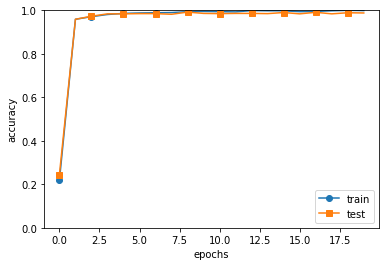

In [5]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


## 이번 장에서 배운 내용
* CNN은 지금까지의 완전연결 계층 네트워크에 합성곱 계층과 풀링 계층을 새로 추가한다.
* 합성곱 계층과 풀링 계층은 im2col (이미지를 행렬로 전개하는 함수)을 이용하면 간단하고 효율적으로 구현할 수 있다.
* CNN을 시각화해보면 계층이 깊어질수록 고급 정보가 추출되는 모습을 확인할 수 있다.
* 대표적인 CNN에는 LeNet과 AlexNet이 있다.
* 딥러닝의 발전에는 빅 데이터와 GPU가 크게 기여했다.